## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Activation, PReLU, Add

## Prepare data for model training

In [2]:
with open("../input/workation-price-prediction-preprocess-data-v4/Workation_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']
train_df.drop(['Per Person Price'], inplace=True, axis=1)

del processed_data
gc.collect()

22

In [3]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
combined_df.head()

,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,pkg_embed_7,...,sightseeing_embed_1020,sightseeing_embed_1021,sightseeing_embed_1022,sightseeing_embed_1023,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination
0,5.199338,-0.523537,1.275303,0.506347,0.941700,-0.360174,-1.713221,-0.147317,-0.969681,-1.082195,...,5.199337,0.269184,-0.920412,-1.744448,0.199538,0.744694,-5.199338,-5.199338,-5.199338,-5.199338
1,-5.199338,5.199338,0.981540,1.894803,1.005049,-0.899252,-0.015453,0.142245,0.279577,0.489307,...,0.853480,-0.465405,0.559859,-0.299230,-5.199338,1.192071,0.166367,0.081638,0.533636,-0.293986
2,-5.199338,0.401995,-0.940393,0.079119,0.352159,-1.048748,0.106841,-0.208278,-1.340200,-0.341493,...,0.149853,-1.102710,0.567211,-0.291367,-5.199338,0.744694,0.981540,0.949547,0.205941,0.558392
3,-5.199338,5.199338,0.914679,-1.784754,-1.236332,0.658043,-0.558392,0.280911,1.358913,1.298197,...,-0.877196,1.365162,-0.370902,0.540882,-5.199338,0.744694,-0.085414,0.949547,-0.524976,-0.358833
4,-5.199338,5.199338,-2.535339,1.847553,-0.966218,1.910600,-0.437290,0.288750,0.392492,0.241963,...,-0.973449,0.469603,1.397836,0.198259,-5.199338,-1.456896,-1.283836,-0.816150,0.908975,-1.031509


In [4]:
class SwapNoise(Sequence):

    def __init__(self, data, swap_perc=0.15, batch_size=128, shuffle=True):
        self.batch_size = batch_size
        self.data = data
        self.swap_perc = swap_perc
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        return self.data.shape[0] // self.batch_size


    def __getitem__(self, index):
        indices = [i for i in range(index*self.batch_size, 
                                    (index+1)*self.batch_size)]
        noisy = self.swap_noise(self.data[indices])
        return (noisy), self.data[indices]


    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.data)


    def get_data(self):
        return self.data


    def swap_noise(self, temp):
        for index in range(temp.shape[0]):            
            num_swaps = np.random.binomial(temp.shape[1], 
                                           self.swap_perc, 
                                           size=1)
            if num_swaps ==0:
                num_swaps=1

            swap_rvs = np.random.normal(size=num_swaps)
            positions_in_row = np.random.choice(a=range(2,temp.shape[1]), 
                                                size=num_swaps, 
                                                replace=False)
            temp[index, positions_in_row] = swap_rvs
        
        return temp

In [5]:
mini_batch_size = 128

train_, test_ = train_test_split(combined_df, test_size=0.25)
print("train_: {} \ntest_: {}".format(train_.shape, test_.shape))

Xtrain = SwapNoise(train_.values, swap_perc=0.15, 
                   batch_size=mini_batch_size, shuffle=True)
Xtest = SwapNoise(test_.values, swap_perc=0.15, 
                  batch_size=mini_batch_size, shuffle=True)

train_: (22498, 5752) 
test_: (7500, 5752)


## Build the model

In [6]:
def autoencoder(n_features, embed_dim=3072):

    x_input = Input(shape=(n_features, ), name='Encoder-Input')

    xe1 = Dense(units=5120, name='Encoder-Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(x_input)
    xe1 = BatchNormalization(name='Encoder-BatchNorm-1')(xe1)
    xe1 = Activation('swish', name='Encoder-Swish-1')(xe1)

    xe2 = Dense(units=4096, name='Encoder-Dense-2', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe1)
    xe2 = BatchNormalization(name='Encoder-BatchNorm-2')(xe2)
    xe2 = Activation('swish', name='Encoder-Swish-2')(xe2)
    
    xe3 = Dense(units=5120, name='Encoder-Dense-3', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe2)
    xe3 = BatchNormalization(name='Encoder-BatchNorm-3')(xe3)
    xe3 = Activation('swish', name='Encoder-Swish-3')(xe3)
    xe3 = Add(name='Encoder-Add-3')([xe1, xe3])

    xe3 = Dense(units=embed_dim, name='Embed-Dense', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe3)
    xe3 = BatchNormalization(name='Embed-BatchNorm')(xe3)
    embed = Activation('swish', name='Embedding')(xe3)
    
    xd1 = Dense(units=5120, name='Decoder-Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(embed)
    xd1 = BatchNormalization(name='Decoder-BatchNorm-1')(xd1)
    xd1 = Activation('swish', name='Decoder-Swish-1')(xd1)

    xd2 = Dense(units=4096, name='Decoder-Dense-2', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xd1)
    xd2 = BatchNormalization(name='Decoder-BatchNorm-2')(xd2)
    xd2 = Activation('swish', name='Decoder-Swish-2')(xd2)
    
    xd3 = Dense(units=5120, name='Decoder-Dense-3', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xd2)
    xd3 = BatchNormalization(name='Decoder-BatchNorm-3')(xd3)
    xd3 = Activation('swish', name='Decoder-Swish-3')(xd3)
    xd3 = Add(name='Decoder-Add-3')([xd1, xd3])

    x_output = Dense(units=n_features, name='Decoder-Output', 
                     kernel_initializer='he_uniform')(xd3)

    model = Model(inputs=x_input, outputs=x_output, name='Autoencoder_Model')
    return model

In [7]:
model = autoencoder(train_.shape[1])
model.compile(loss='mean_squared_error',
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

early = EarlyStopping(monitor="val_loss", mode="min", 
                      restore_best_weights=True, 
                      patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-6, patience=5, 
                              verbose=1, mode='min')

chk_point = ModelCheckpoint('./DAE_model.h5', 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')

In [8]:
model.summary()

Model: "Autoencoder_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      [(None, 5752)]       0                                            
__________________________________________________________________________________________________
Encoder-Dense-1 (Dense)         (None, 5120)         29455360    Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-BatchNorm-1 (BatchNorma (None, 5120)         20480       Encoder-Dense-1[0][0]            
__________________________________________________________________________________________________
Encoder-Swish-1 (Activation)    (None, 5120)         0           Encoder-BatchNorm-1[0][0]        
__________________________________________________________________________________

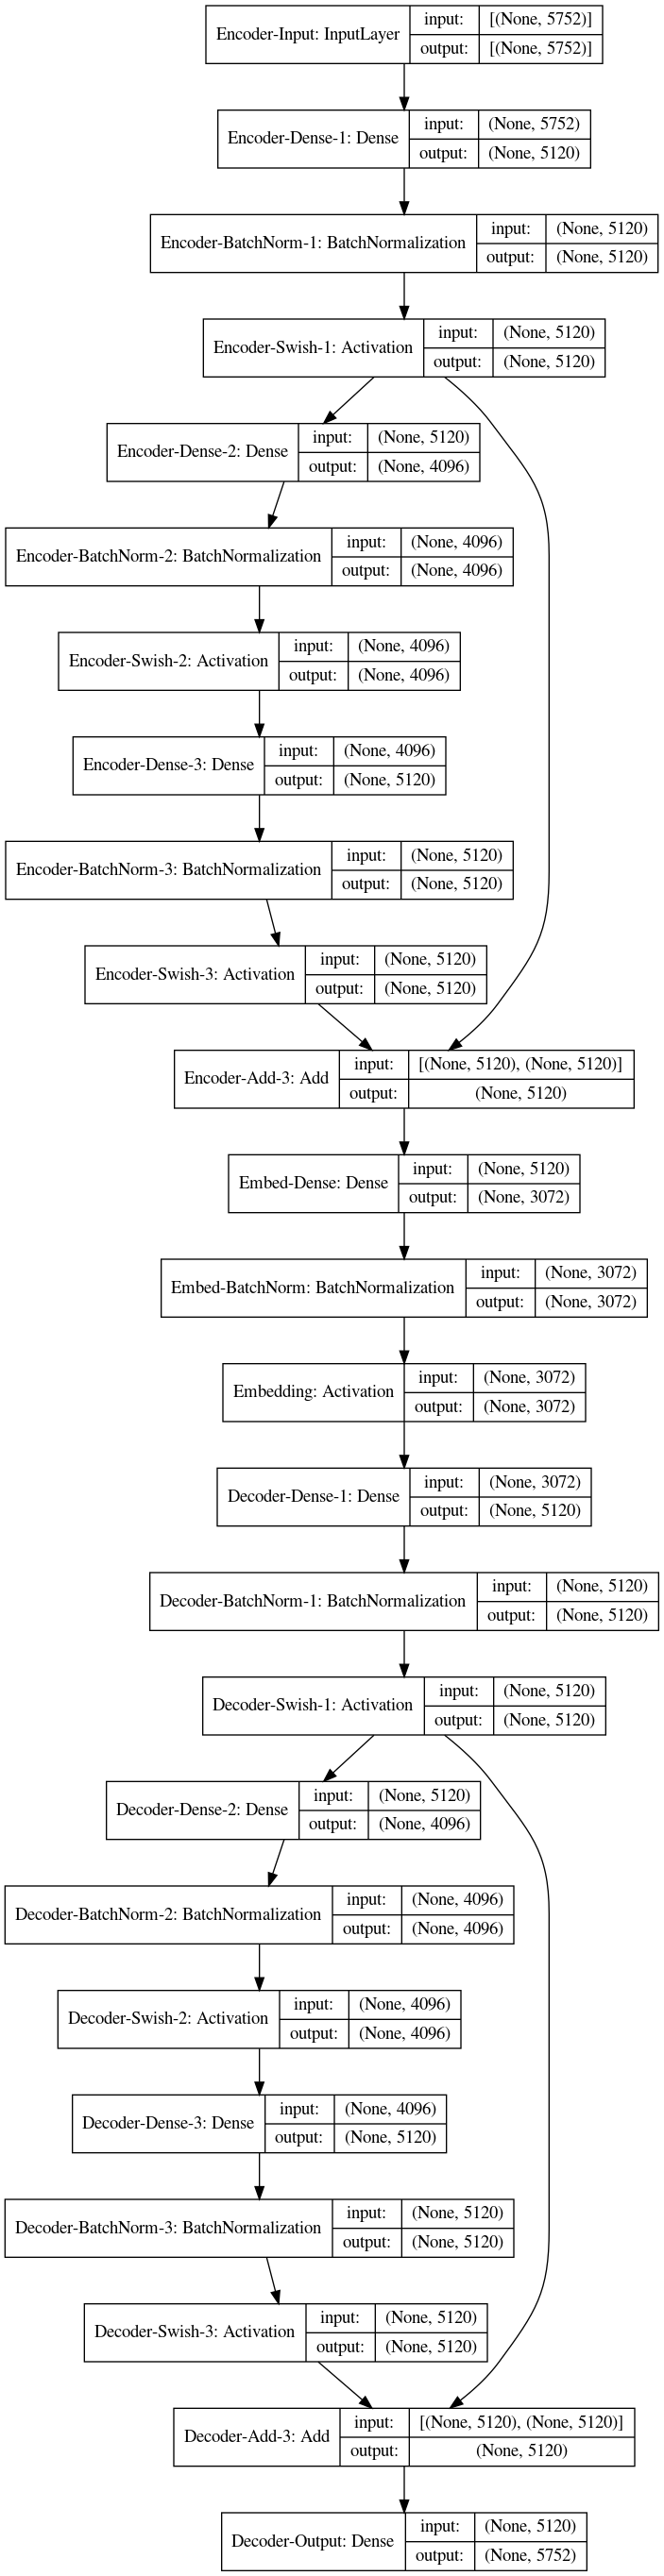

In [9]:
plot_model(
    model, to_file='./DAE_model.png', 
    show_shapes=True, show_layer_names=True
)

In [10]:
history = model.fit(
    Xtrain, 
    batch_size=mini_batch_size,
    epochs=275, 
    verbose=1, 
    workers=5,
    callbacks=[reduce_lr, early, chk_point], 
    validation_data=Xtest
)

Epoch 1/275
175/175 [==============================] - 78s 386ms/step - loss: 103.3862 - val_loss: 12.7306

Epoch 00001: val_loss improved from inf to 12.73059, saving model to ./DAE_model.h5
Epoch 2/275
175/175 [==============================] - 66s 373ms/step - loss: 8.2327 - val_loss: 2.4031

Epoch 00002: val_loss improved from 12.73059 to 2.40311, saving model to ./DAE_model.h5
Epoch 3/275
175/175 [==============================] - 69s 387ms/step - loss: 2.6931 - val_loss: 2.4140

Epoch 00003: val_loss did not improve from 2.40311
Epoch 4/275
175/175 [==============================] - 68s 381ms/step - loss: 5.3480 - val_loss: 1.9550

Epoch 00004: val_loss improved from 2.40311 to 1.95504, saving model to ./DAE_model.h5
Epoch 5/275
175/175 [==============================] - 69s 387ms/step - loss: 5.2901 - val_loss: 2.4200

Epoch 00005: val_loss did not improve from 1.95504
Epoch 6/275
175/175 [==============================] - 69s 388ms/step - loss: 3.4281 - val_loss: 1.8467

Epoch 

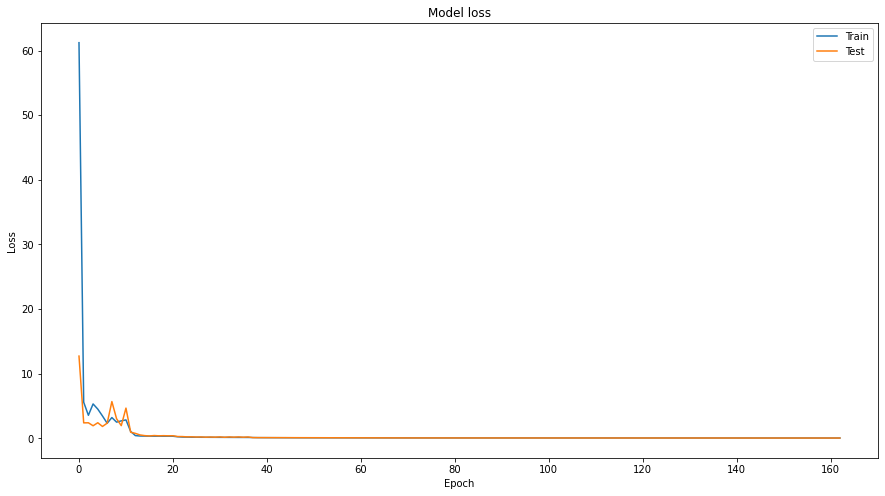

In [11]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Validate autoencoder output

In [12]:
model = load_model('./DAE_model.h5')
y_pred = model.predict(test_.values)
y_pred.shape

(7500, 5752)

In [13]:
test_.head()

,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,pkg_embed_7,...,sightseeing_embed_1020,sightseeing_embed_1021,sightseeing_embed_1022,sightseeing_embed_1023,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination
19371,0.163824,-0.523537,1.096605,1.135894,2.319396,-0.993754,-1.155521,0.644172,-1.072919,-0.027698,...,-0.423691,-0.624206,-0.075242,-1.006675,5.199338,-0.733156,-0.372246,-0.391137,0.908975,0.087933
1089,5.199338,-0.523537,0.378942,1.452879,-0.172730,-0.734152,-0.895332,-0.764710,-1.926403,-0.552537,...,0.931971,-0.166367,0.300542,-0.235509,0.199538,0.744694,-0.085414,0.081638,0.205941,-0.358833
22097,5.199338,-0.523537,-0.724307,0.687064,0.894881,-1.117363,-3.452394,-0.912721,0.020375,-1.964329,...,5.199337,0.269184,-0.920412,-1.744448,0.199538,-0.188033,-5.199338,0.081638,-5.199338,-5.199338
12537,-5.199338,5.199338,1.016634,-0.855287,-1.097845,-1.010382,-1.102440,-0.091712,0.081638,1.053106,...,-0.839359,0.689529,-0.082345,2.196894,-5.199338,1.460531,1.705570,1.705570,-0.524976,0.746351
22901,5.199338,-0.523537,0.999276,1.199766,0.254902,-0.829057,-0.168650,1.403495,-0.089193,-1.626244,...,0.297843,-0.509202,-1.384306,-3.054713,0.199538,5.199338,-1.075207,5.199338,-0.037646,-1.386594


In [14]:
df = pd.DataFrame(y_pred, columns=test_.columns)
df.head()

,Flight Stops,Meals,pkg_embed_0,pkg_embed_1,pkg_embed_2,pkg_embed_3,pkg_embed_4,pkg_embed_5,pkg_embed_6,pkg_embed_7,...,sightseeing_embed_1020,sightseeing_embed_1021,sightseeing_embed_1022,sightseeing_embed_1023,meals_per_flight_stops,destination_per_day,sightseeing_per_day,hotels_per_day,airline_per_destination,sightseeing_per_destination
0,0.676779,-0.393249,0.613598,1.253221,1.937264,-0.494194,-1.388179,0.066133,-0.510190,-0.451922,...,-0.725967,-0.476973,-0.715158,-0.855282,4.709243,-0.702289,-0.329877,-0.129211,0.630248,0.106296
1,5.002788,-0.450913,0.232001,1.762693,-0.046681,-0.928873,-0.521879,-0.926042,-1.850759,-0.489488,...,0.880075,-0.078023,0.507608,-0.167072,-0.126326,1.363143,-0.033542,0.375128,-0.383671,-0.274596
2,4.243374,-0.656978,-0.212238,0.710879,0.825572,-0.715443,-3.095978,-0.824042,-0.142898,-1.982511,...,5.415949,0.212449,-1.218210,-2.058241,1.624124,-0.110938,-5.323149,0.417089,-5.199968,-5.359367
3,-5.008191,4.982258,0.635247,-0.782393,-1.098889,-0.845300,-0.998636,0.058935,-0.039558,0.992886,...,-0.817138,0.202584,-0.178824,2.370751,-5.004349,1.538679,1.500629,1.711809,-0.627577,0.714540
4,5.437851,-0.440899,1.070620,1.182593,0.289162,-1.040644,0.134955,1.456893,-0.327676,-1.890311,...,0.272397,-0.429573,-2.003662,-3.217410,-0.201200,6.042510,-1.009483,5.901039,-0.007493,-1.914551


In [15]:
mse = (np.square(test_.values - df.values)).mean()
print("MSE: {}".format(mse))

MSE: 0.04008780733594997
